In [1]:
import sys
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import sumolib
import traci
from sumolib import checkBinary
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch
import sys
import io
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from collections import namedtuple, deque
import gym
from torch_geometric.utils import dense_to_sparse
import copy
from itertools import count

if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))

# sumoBinary = checkBinary('sumo-gui')
sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Using device: " + str(device))

SUMO_HOME found
Using device: cuda


In [2]:
def intervehicleConnectivity(threshold = None):
    xs = []
    ys = []
    for vehicle in traci.vehicle.getIDList():
        x, y = traci.vehicle.getPosition(vehicle)
        xs.append(x)
        ys.append(y)
    xs = torch.tensor(xs, dtype=torch.float32).view(-1,1)
    ys = torch.tensor(ys, dtype=torch.float32).view(-1,1)
    intervehicle_distances = torch.sqrt((xs - xs.t())**2 + (ys - ys.t())**2)
    if threshold is not None:
        # make the distances 1 if less than the threshold, 0 otherwise
        connectivity = torch.where(intervehicle_distances < threshold, torch.ones_like(intervehicle_distances), torch.zeros_like(intervehicle_distances))
    return connectivity

In [3]:
def randomTrips(dur=1000, density=12):
    os.system("python $SUMO_HOME/tools/randomTrips.py -n config/osm.net.xml.gz -r config/osm.passenger.trips.xml -e " + str(dur) + " -l --insertion-density=" + str(density))

def shouldContinueSim():
    numVehicles = traci.simulation.getMinExpectedNumber()
    return True if numVehicles > 0 else False

def restart(sumoCmd):
    with io.StringIO() as buf, redirect_stdout(buf):
        try:
            traci.close()
        except:
            pass
        traci.start(sumoCmd)

def close():
    traci.close()

randomTrips(800, 1.5)

Success.


In [140]:
def bfs_distance(adj_matrix):
    n_hop_matrix = torch.ones_like(adj_matrix) * (-100)
    for start_node in range(adj_matrix.size(0)):
        visited = [0] * adj_matrix.size(0)
        queue = deque([(start_node, 0)])
        visited[start_node] = True
        
        while queue:
            current_node, current_dist = queue.popleft()
            
            for neighbor, connected in enumerate(adj_matrix[current_node]):
                if connected and not visited[neighbor]:
                    queue.append((neighbor, current_dist + 1))
                    visited[neighbor] = True
                    n_hop_matrix[start_node, neighbor] = current_dist + 1
    return n_hop_matrix

In [147]:
class RoutingGym(gym.Env):
    def __init__(self, sumoCmd, max_steps=1100, n_nodes=57, max_routing_steps=100):
        self.sumoCmd = sumoCmd
        self.step_counter = 0
        self.max_steps = max_steps
        self.n_nodes = n_nodes
        self.vehicle_ids = None
        self.start_node = None
        self.end_node = None
        self.current_node = None
        self.node_features = None
        self.adj_matrix = None
        self.edge_index = None
        self.hop_thresh = None
        self.routing_done = False
        self.routing_steps = 0
        self.min_n_hops = None
        self.end_node_indicator = torch.zeros(n_nodes)
        self.max_routing_steps = max_routing_steps
        self.n_hop_matrix = None
        self.neighbors_indicator = None

    def reset(self):
        try:
            traci.close()
        except:
            pass
        traci.start(sumoCmd)
        self.step_counter = 0

        while self.step_counter < 400:
            traci.simulationStep()
            self.step_counter += 1

    def step(self):
        self.end_node_indicator = torch.zeros(self.n_nodes)
        self.routing_done = False
        self.routing_steps = 0
        self.step_counter += 1
        self.vehicle_ids = traci.vehicle.getIDList()
        self.adj_matrix = intervehicleConnectivity(800)
        self.adj_matrix = self.adj_matrix - torch.eye(self.adj_matrix.size(0))
        self.select_start_end_nodes()
        self.current_node = self.start_node
        self.current_node = self.start_node
        self.adj_matrix = F.pad(self.adj_matrix, (0, self.n_nodes - self.adj_matrix.size(0), 0, self.n_nodes - self.adj_matrix.size(1)), "constant", 0)
        self.n_hop_matrix = F.pad(self.n_hop_matrix, (0, self.n_nodes - self.n_hop_matrix.size(0), 0, self.n_nodes - self.n_hop_matrix.size(1)), "constant", -100)
        self.n_hop_matrix = self.n_hop_matrix - torch.diag(torch.diag(self.n_hop_matrix))
        self.edge_index, _ = dense_to_sparse(self.adj_matrix)
        current_node_indicators = torch.zeros(self.n_nodes)
        current_node_indicators[self.current_node] = 1
        self.end_node_indicator[self.end_node] = 1
        self.neighbors_indicator = self.adj_matrix[self.current_node]
        self.node_features = torch.stack((current_node_indicators, 
                                          self.n_hop_matrix[self.current_node], self.end_node_indicator, self.neighbors_indicator)).T
        
        return self.node_features.to(device)

    def select_start_end_nodes(self):
        self.n_hop_matrix = bfs_distance(self.adj_matrix)
        self.hop_thresh = min(self.n_hop_matrix.max(), 5)
        starts, ends = torch.where(self.hop_thresh == self.n_hop_matrix)
        starts = starts.tolist()
        ends = ends.tolist()
        self.start_node, self.end_node = random.choice(list(zip(starts, ends)))
        # minimal number of hops between start and end nodes
        self.min_n_hops = self.n_hop_matrix[self.start_node, self.end_node]

    def act(self, neighbor_index):
        self.routing_steps += 1
        neighbors = torch.where(self.adj_matrix[self.current_node] == 1)[0]
        valid_action_size = len(neighbors)
        if valid_action_size <= neighbor_index:
            if self.node_features.device != device:
                self.node_features = self.node_features.to(device)
            self.routing_done = self.routing_steps >= self.max_routing_steps
            if self.routing_done:
                return self.node_features, torch.tensor(-1).to(device), True
            return self.node_features, torch.tensor(-0.15).to(device), False
        else:
            next_hop = neighbors[neighbor_index]
            reward = self.compute_reward(next_hop)
            self.current_node = next_hop
            curr_node_indicators = torch.zeros(self.n_nodes)
            curr_node_indicators[self.current_node] = 1
            self.neighbors_indicator = self.adj_matrix[self.current_node]
            self.node_features = torch.stack((curr_node_indicators, 
                                              self.n_hop_matrix[self.current_node], self.end_node_indicator, self.neighbors_indicator)).T
            return self.node_features.to(device), torch.tensor(reward).to(device), self.routing_done
    
    def good_action(self):
        current_distance_to_end = self.n_hop_matrix[self.current_node, self.end_node]
        neighbors_closer_to_end = torch.where(self.n_hop_matrix[self.current_node] < current_distance_to_end)[0]
        assert len(neighbors_closer_to_end) > 0
        return torch.tensor([random.choice(neighbors_closer_to_end)], device=device)
    
    def get_action_mask(self):
        action_mask = copy.deepcopy(self.adj_matrix[self.current_node])
        action_mask = F.pad(action_mask, (0, self.n_nodes - action_mask.size(0)), "constant", 0).to(device)
        return action_mask

    def get_adj_matrix(self):
        return copy.deepcopy(self.adj_matrix).to(device)
    
    def get_edge_index(self):
        return copy.deepcopy(self.edge_index).to(device)
        
    def compute_reward(self, next_hop):
        if self.routing_steps >= self.max_routing_steps:
            # print("Failed, ", self.min_n_hops)
            self.routing_done = True
            return -1
        elif next_hop == self.end_node:
            # print("Routing done, number of hops: ", self.routing_steps, " minimum number of hops: ", self.min_n_hops)
            self.routing_done = True
            return (self.min_n_hops / self.routing_steps)
        elif self.n_hop_matrix[self.current_node, self.end_node] > self.n_hop_matrix[next_hop, self.end_node]:
            return 0.1
        else:
            return -0.15
        
    def sim_done(self):
        """
        function: get the done state of simulation.
        """
        return not (shouldContinueSim() and self.step_counter <= self.max_steps)

In [142]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, n_nodes=57, hidden_dim=64, dropout=0.1, max_n_neighbors=15):
        super(DQN, self).__init__()
        self.n_nodes = n_nodes
        self.hidden_dim = hidden_dim
        self.convs1 = GCNConv(in_channels, hidden_dim)
        self.convs2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(in_channels * n_nodes, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, n_nodes)
        self.fc5 = nn.Linear(n_nodes, max_n_neighbors)
        self.softmax = nn.Softmax(dim=1)
        self.selu = nn.SELU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = x.reshape(-1, self.n_nodes * 4)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)
        x = self.selu(x)
        x = self.fc3(x)
        x = self.selu(x)
        x = self.fc4(x)
        x = self.selu(x)
        x = self.fc5(x)
        return x



Transition = namedtuple('Transition',
                        ('data', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [127]:
class GDQN(nn.Module):
    def __init__(self, in_channels=4, n_nodes=57, hidden_dim=64, dropout=0.1, max_n_neighbors=15):
        super(GDQN, self).__init__()
        self.n_nodes = n_nodes
        self.hidden_dim = hidden_dim
        self.convs1 = GCNConv(in_channels, hidden_dim)
        self.convs2 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim * n_nodes, n_nodes)
        self.fc2 = nn.Linear(n_nodes, max_n_neighbors)
        self.softmax = nn.Softmax(dim=1)
        self.selu = nn.SELU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.convs1(x, edge_index)
        x = self.selu(x)
        x = self.convs2(x, edge_index)
        x = self.selu(x)
        x = x.reshape(-1, self.n_nodes * self.hidden_dim)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)
        return x

In [128]:
class DummyEnv(gym.Env):
    def __init__(self):
        super(DummyEnv, self).__init__()
        self.adj_matrix = torch.tensor([[1, 1, 0, 0, 1, 1, 0, 0],
                                        [1, 1, 1, 0, 1, 1, 0, 0],
                                        [0, 1, 1, 1, 0, 0, 1, 1],
                                        [0, 0, 1, 1, 0, 0, 0, 0],
                                        [1, 1, 0, 0, 1, 0, 1, 0],
                                        [1, 1, 0, 0, 0, 1, 0, 0],
                                        [0, 0, 1, 0, 1, 0, 1, 0],
                                        [0, 0, 1, 0, 0, 0, 0, 1]])
        self.adj_matrix = self.adj_matrix - torch.eye(self.adj_matrix.size(0))
        self.n_hop_matrix = bfs_distance(self.adj_matrix)
        self.n_hop_matrix = self.n_hop_matrix - torch.diag(torch.diag(self.n_hop_matrix))
        print(self.n_hop_matrix)
        self.num_nodes = self.adj_matrix.size(0)
        self.start_node = 0
        self.end_node = 3
        self.current_node = self.start_node
        self.edge_index = dense_to_sparse(self.adj_matrix)[0]
        self.routing_steps = 0
        self.end_node_indicator = torch.zeros(self.num_nodes)
        self.end_node_indicator[self.end_node] = 1
        self.routing_done = False
        self.max_routing_steps = 10
        self.min_n_hops = 3
        self.n_nodes = 8

    def reset(self):
        pass

    def get_edge_index(self):
        return copy.deepcopy(self.edge_index).to(device)

    def step(self):
        self.routing_done = False
        self.select_start_end_nodes()
        self.current_node = self.start_node
        self.routing_steps = 0
        self.current_node_indicator = torch.zeros(self.num_nodes)
        self.current_node_indicator[self.current_node] = 1
        self.neighbors_indicator = self.adj_matrix[self.current_node]
        self.node_features = torch.stack((self.current_node_indicator, self.n_hop_matrix[self.current_node], self.end_node_indicator, self.neighbors_indicator)).T
        return self.node_features.to(device)
    
    def select_start_end_nodes(self):
        self.hop_thresh = min(self.n_hop_matrix.max(), 2)
        starts, ends = torch.where(self.hop_thresh <= self.n_hop_matrix)
        starts = starts.tolist()
        ends = ends.tolist()
        self.start_node, self.end_node = random.choice(list(zip(starts, ends)))
        self.end_node_indicator = torch.zeros(self.num_nodes)
        self.end_node_indicator[self.end_node] = 1
        # minimal number of hops between start and end nodes
        self.min_n_hops = self.n_hop_matrix[self.start_node, self.end_node]
    
    def act(self, neighbor_index):
        self.routing_steps += 1
        neighbors = torch.where(self.adj_matrix[self.current_node] == 1)[0]
        valid_action_size = len(neighbors)
        if valid_action_size <= neighbor_index:
            if self.node_features.device != device:
                self.node_features = self.node_features.to(device)
            self.routing_done = self.routing_steps >= self.max_routing_steps
            if self.routing_done:
                return self.node_features, torch.tensor(-1).to(device), True
            return self.node_features, torch.tensor(-0.15).to(device), self.routing_done
        else:
            next_hop = neighbors[neighbor_index]
            reward = self.compute_reward(next_hop)
            self.current_node = next_hop
            curr_node_indicators = torch.zeros(self.n_nodes)
            curr_node_indicators[self.current_node] = 1
            self.neighbors_indicator = self.adj_matrix[self.current_node]
            self.node_features = torch.stack((curr_node_indicators, 
                                              self.n_hop_matrix[self.current_node], self.end_node_indicator, self.neighbors_indicator)).T
            return self.node_features.to(device), torch.tensor(reward).to(device), self.routing_done
    
    def compute_reward(self, next_hop):
        if self.routing_steps >= self.max_routing_steps:
            # print("Failed, ", self.start_node, self.end_node)
            self.routing_done = True
            return -1
        elif next_hop == self.end_node:
            # print("Routing done, number of hops: ", self.routing_steps, " minimum number of hops: ", self.min_n_hops)
            self.routing_done = True
            return (self.min_n_hops / self.routing_steps)
        elif self.n_hop_matrix[self.current_node, self.end_node] > self.n_hop_matrix[next_hop, self.end_node]:
            return 0.1
        else:
            return -0.15

    def get_action_mask(self):
        action_mask = copy.deepcopy(self.adj_matrix[self.current_node])
        action_mask = F.pad(action_mask, (0, 4 - action_mask.size(0)), "constant", 0).to(device)
        return action_mask

In [133]:
BATCH_SIZE = 128
GAMMA = 0.9
GAMMA = 0.9
EPS_START = 0.2
EPS_END = 0.001
EPS_DECAY = 600
TAU = 0.005
LR = 0.001

def select_action(data, action_mask):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(data).max(1).indices.view(-1)
    else:
        valid_size = len(torch.where(action_mask == 1)[0])
        return torch.randint(0, valid_size, (1,), device=device)

In [134]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = Batch.from_data_list([s for s in batch.next_state
                                                if s is not None])
    data_batch = Batch.from_data_list(batch.data)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.concat(batch.reward)
  

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(data_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [143]:
def train(iter=100):
    reward_history = []
    env.reset()
    episode_num = 0
    for i in range(iter):
        state = env.step()
        episode_num += 1
        edge_index = env.get_edge_index()
        routing_done = False
        accumulated_reward = 0
        while not routing_done:
            action_mask = env.get_action_mask()
            data = Data(x=state, edge_index=edge_index)
            action = select_action(data, action_mask)
            node_features, reward, routing_done = env.act(action.item())
            reward = torch.tensor([reward], device=device)
            accumulated_reward += reward.item()

            routing_done = routing_done

            if routing_done:
                next_state = None
                memory.push(data, action, None, reward)
            else:
                next_state = node_features
                memory.push(data, action, Data(x=next_state, edge_index=edge_index), reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)
        if episode_num % 50 == 0:
            print("Episode: ", episode_num, " Accumulated reward: ", accumulated_reward)
        reward_history.append(accumulated_reward)
    return reward_history

In [148]:
# env = DummyEnv()

# policy_net = DQN(n_nodes=8).to(device)
# target_net = DQN(n_nodes=8).to(device)
# target_net.load_state_dict(policy_net.state_dict())

# optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
# memory = ReplayMemory(10000)
# steps_done = 0

# reward_history = train(10000)

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of DQN')]

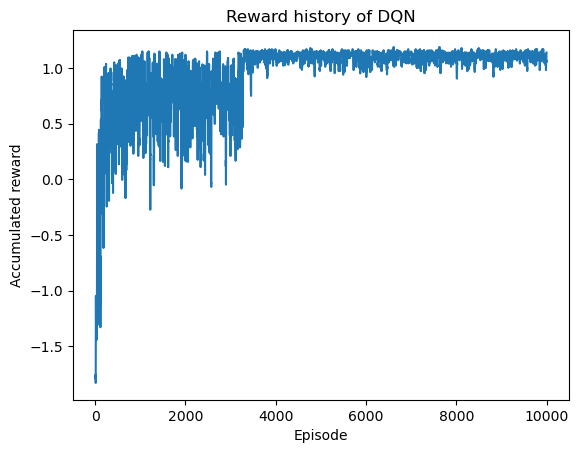

In [112]:
# # save reward history
# reward_history = pd.DataFrame(reward_history)
# reward_history.to_csv('reward_history_dqn_dummy.csv', index=False)
# # smooth the reward history
# reward_history = reward_history.rolling(window=10).mean()
# fig, ax = plt.subplots()
# ax.plot(reward_history)
# ax.set(xlabel='Episode', ylabel='Accumulated reward',
#        title='Reward history of DQN')

In [149]:
# env = DummyEnv()

# policy_net = GDQN(n_nodes=8).to(device)
# target_net = GDQN(n_nodes=8).to(device)
# target_net.load_state_dict(policy_net.state_dict())

# optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
# memory = ReplayMemory(10000)

# steps_done = 0

# reward_history = train(10000)

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of GDQN')]

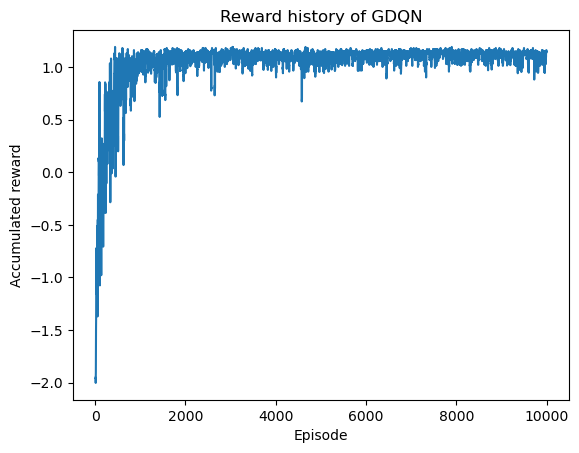

In [121]:
# # save reward history
# reward_history = pd.DataFrame(reward_history)
# reward_history.to_csv('reward_history_gdqn_dummy.csv', index=False)
# # smooth the reward history
# reward_history = reward_history.rolling(window=10).mean()
# fig, ax = plt.subplots()
# ax.plot(reward_history)
# ax.set(xlabel='Episode', ylabel='Accumulated reward',
#        title='Reward history of GDQN')

Simulation ended at time: 400.00
Reason: TraCI requested termination.
Performance: 
 Duration: 218.21s
 TraCI-Duration: 0.01s
 Real time factor: 1.83308
 UPS: 38.865874
Vehicles: 
 Inserted: 45 (Loaded: 48)
 Running: 39
 Waiting: 0
Statistics (avg of 6):
 RouteLength: 1965.69
 Speed: 10.02
 Duration: 203.50
 WaitingTime: 1.83
 TimeLoss: 23.67
 DepartDelay: 0.35

 Retrying in 1 seconds
***Starting server on port 60261 ***
Loading net-file from './config/osm.net.xml.gz' ... done (111ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_21982/3940573057.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.node_features.to(device), torch.tensor(reward).to(device), self.routing_done


Episode:  50  Accumulated reward:  -4.850000262260437
Episode:  100  Accumulated reward:  0.08461536467075348
Episode:  150  Accumulated reward:  1.4000000059604645
Episode:  200  Accumulated reward:  1.4000000059604645
Episode:  250  Accumulated reward:  -6.10000029951334
Episode:  300  Accumulated reward:  1.4000000059604645
Episode:  350  Accumulated reward:  1.4000000059604645
Episode:  400  Accumulated reward:  0.8555555790662766
Episode:  450  Accumulated reward:  1.0833333134651184
Episode:  500  Accumulated reward:  1.4000000059604645
Episode:  550  Accumulated reward:  1.4000000059604645
Episode:  600  Accumulated reward:  1.4000000059604645
Episode:  650  Accumulated reward:  1.4000000059604645
Episode:  700  Accumulated reward:  1.4000000059604645
Episode:  750  Accumulated reward:  1.4000000059604645
Episode:  800  Accumulated reward:  1.4000000059604645
Episode:  850  Accumulated reward:  1.4000000059604645
Episode:  900  Accumulated reward:  1.4000000059604645
Episode:  9

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of DQN')]

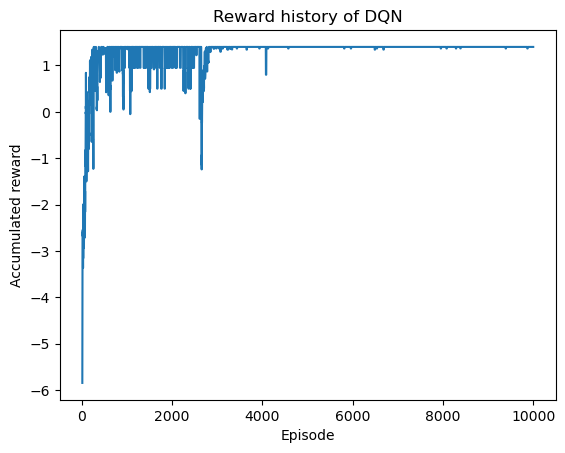

In [150]:
n_nodes = 57
env = RoutingGym(sumoCmd, 1100, n_nodes)
policy_net = DQN(n_nodes=n_nodes).to(device)
target_net = DQN(n_nodes=n_nodes).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0

reward_history = train(10000)

# save reward history
reward_history = pd.DataFrame(reward_history)
reward_history.to_csv('reward_history_dqn_large.csv', index=False)
# smooth the reward history
reward_history = reward_history.rolling(window=10).mean()
fig, ax = plt.subplots()
ax.plot(reward_history)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history of DQN')

Simulation ended at time: 400.00
Reason: TraCI requested termination.
Performance: 
 Duration: 771.05s
 TraCI-Duration: 0.01s
 Real time factor: 0.518776
 UPS: 10.999344
Vehicles: 
 Inserted: 45 (Loaded: 48)
 Running: 39
 Waiting: 0
Statistics (avg of 6):
 RouteLength: 1965.69
 Speed: 10.02
 Duration: 203.50
 WaitingTime: 1.83
 TimeLoss: 23.67
 DepartDelay: 0.35

 Retrying in 1 seconds
***Starting server on port 37187 ***
Loading net-file from './config/osm.net.xml.gz' ... done (107ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_21982/3940573057.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.node_features.to(device), torch.tensor(reward).to(device), self.routing_done


Episode:  50  Accumulated reward:  -4.100000239908695
Episode:  100  Accumulated reward:  -1.7809524983167648
Episode:  150  Accumulated reward:  1.0833333134651184
Episode:  200  Accumulated reward:  -8.600000374019146
Episode:  250  Accumulated reward:  1.0833333134651184
Episode:  300  Accumulated reward:  -0.21481487154960632
Episode:  350  Accumulated reward:  1.4000000059604645
Episode:  400  Accumulated reward:  0.8555555790662766
Episode:  450  Accumulated reward:  0.8555555790662766
Episode:  500  Accumulated reward:  0.8142857253551483
Episode:  550  Accumulated reward:  -3.0863637924194336
Episode:  600  Accumulated reward:  0.26666663587093353
Episode:  650  Accumulated reward:  1.0833333134651184
Episode:  700  Accumulated reward:  1.4000000059604645
Episode:  750  Accumulated reward:  1.064285732805729
Episode:  800  Accumulated reward:  1.4000000059604645
Episode:  850  Accumulated reward:  1.4000000059604645
Episode:  900  Accumulated reward:  1.0833333134651184
Episode

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of GDQN')]

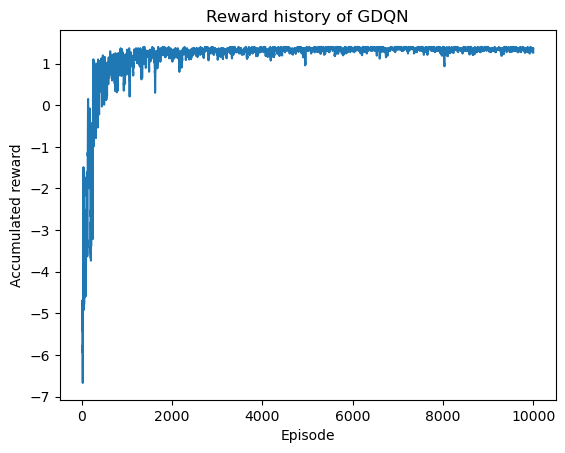

In [151]:
n_nodes = 57
env = RoutingGym(sumoCmd, 1100, n_nodes)
policy_net = GDQN(n_nodes=n_nodes).to(device)
target_net = GDQN(n_nodes=n_nodes).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0

reward_history = train(10000)

# save reward history
reward_history = pd.DataFrame(reward_history)
reward_history.to_csv('reward_history_gdqn_large.csv', index=False)
# smooth the reward history
reward_history = reward_history.rolling(window=10).mean()
fig, ax = plt.subplots()
ax.plot(reward_history)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history of GDQN')